# Karcher mean computation
Given a set of $n\times n$ positive definite matrices $A_1,\dots,A_m$, the Karcher mean is the unique positive definite solution $X$ to the equation $\sum_{i = 1}^m \log(A^{-1}_i X)$, where $\log$ is the matrix logarithm. This matrix average has many desirable properties (complete list in Ando (2004)), which make its fast computation relevant to signal progessing, medical imaging and elasticity. It turns out that such mean can be written as the solution to the optimization problem
$$\text{argmin}_{X\in\mathcal{S}^{++}(d)} \ f(X)=\frac{1}{2m}\sum_{i=1}^m d(A_i,X)^2.$$
Clearly, $f$ is strongly-convex with modulus $\mu=1$, and $L$-smooth with modulus estimated to be around $5$ (see Zhang and Sra 2016).

In [36]:
#libraries to import
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt 
from scipy.linalg import sqrtm, logm, expm
from utils import random_psd, karcher_mean
from geometric_optimizers import RGD_optimizer, RAGD_optimizer,RAGDsDR_optimizer
from pymanopt.manifolds import PositiveDefinite
import torch
import time
%config InlineBackend.figure_format = 'svg'

### Hyperparameters for problem definition and solution

In [37]:
# problem hyperparameters
seed = 40 #for reproducibility
d = 100 #problem dimension
kappa = 1e6 #condition number of matrices
n = 10 #number of matrices to average

# algorithm hyperparameters
accuracy = 1e-5 #accuracy of the numerical solution (Zhang and Sra 2016)
N=100 #number of iterations for optimizers
line_search_iterations = 10

### Problem definition and numerical solution

In [38]:
A = np.zeros((d,d,n)) #list of matrices to average 
np.random.seed(seed) #
matrix_seeds = np.random.randint(0, 1000, n)
for i in range(n): A[:,:,i] = random_psd(d,kappa,matrix_seeds[i]) #initializing matrices at random
print('Computing numerical solution...')
x_sol = karcher_mean(A, accuracy) #basically doing RGD, but in an explicit form with no exp map.

Computing numerical solution...


### Manifold initialization

In [39]:
M = PositiveDefinite(d)   

def dist(X,Y): return M.dist(X,Y)

def log(X,Y): return M.log(X,Y)

def cost(X):
    c=0
    for i in range(n): c += (1/(2*n))*M.dist(A[:,:,i],X)**2
    return c

def grad(X): #see https://www.math.fsu.edu/~whuang2/pdf/VisitBJU_Slides.pdf
    c=0*X
    for i in range(n): c -= (1/n)*log(X,A[:,:,i])
    return c

def exp(X,U): # M.exp(X,U) by pymanopt is unstable!
    c = la.cholesky(X)
    c_inv = la.inv(c)
    e = expm(np.dot(np.dot(c_inv, U),c_inv.T))
    return np.dot(np.dot(c, e), c.T)

def transp(X,Y,U): return M.transp(X,Y,U)

### Optimization  

In [40]:
#initialization
x0 = np.mean(A,axis=2)
L = 5 #as in Zhang and Sra 2016
mu = 1 #the problem is a sum of scaled distances

#running the optimizers
t1, x1, f1 = RGD_optimizer(N,x0,L,cost,grad,exp)
t2, x2, f2 = RAGD_optimizer(N,x0,L,mu,cost,grad,exp,log)
t3, x3, f3, beta3 = RAGDsDR_optimizer(N,x0,L,cost,grad,exp,log,transp,line_search_iterations)
t4, x4, f4, beta4 = RAGDsDR_optimizer(N,x0,L,cost,grad,exp,log,transp,-1)

Running Riemannian GD...
Running Riemannian AGD (Zhang and Sra)...
Running Riemannian AGDsDR(linesearch)...
Running Riemannian AGDsDR(no linesearch)...


### Plotting the results

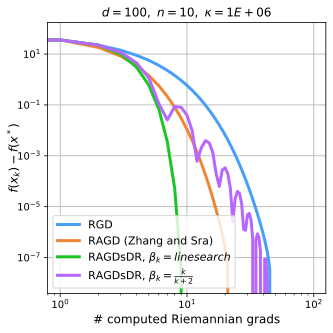

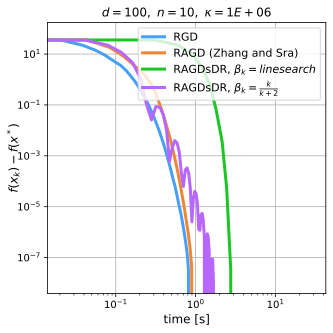

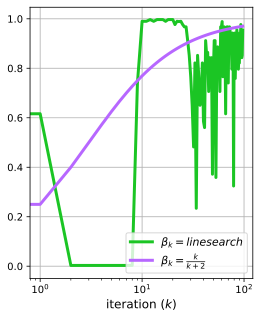

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [42]:
#gradient computations
fig, ax = plt.subplots(figsize=(5,5))
ax.loglog(range(N), f1-cost(x_sol),label='RGD',linewidth=3, color = '#479FF8')
ax.loglog(range(N), f2-cost(x_sol),label='RAGD (Zhang and Sra)',linewidth=3, color='#EF8636')
ax.loglog(range(N), f3-cost(x_sol),label=r'RAGDsDR, $\beta_k = linesearch$',linewidth=3, color='#1BC524')
ax.loglog(range(N), f4-cost(x_sol),label=r'RAGDsDR, $\beta_k = \frac{k}{k+2}$',linewidth=3, color='#B767FF')
plt.xlabel(r'# computed Riemannian grads',size=12)
plt.ylabel(r'$f(x_k)-f(x^*)$',size=12,labelpad=-3)
plt.title(r'$d = %d, \ n= %d, \ \kappa=%1.0E$'%(d,n,kappa))
ax.grid()
ax.legend(fontsize=11)
#ax.set_ylim(bottom=1e-15)
plt.show()
filename='results/KARCHER_iteration_seed'+str(seed)+'_d'+str(d)+'_n'+str(n)+'_kappa'+str(int(kappa))+'.png'
fig.savefig(filename, format='png', dpi=1000)

#time
fig, ax = plt.subplots(figsize=(5,5))
ax.loglog(t1, f1-cost(x_sol),label='RGD',linewidth=3, color = '#479FF8')
ax.loglog(t2, f2-cost(x_sol),label='RAGD (Zhang and Sra)',linewidth=3, color='#EF8636')
ax.loglog(t3, f3-cost(x_sol),label=r'RAGDsDR, $\beta_k = linesearch$',linewidth=3, color='#1BC524')
ax.loglog(t4, f4-cost(x_sol),label=r'RAGDsDR, $\beta_k = \frac{k}{k+2}$',linewidth=3, color='#B767FF')
plt.xlabel(r'time [s]',size=12)
plt.ylabel(r'$f(x_k)-f(x^*)$',size=12,labelpad=-3)
plt.title(r'$d = %d, \ n= %d, \ \kappa=%1.0E$'%(d,n,kappa))
ax.grid()
ax.legend(fontsize=11)
#ax.set_ylim(bottom=1e-15)
plt.show()
filename='results/KARCHER_time_seed'+str(seed)+'_d'+str(d)+'_n'+str(n)+'_kappa'+str(int(kappa))+'.png'
fig.savefig(filename, format='png', dpi=1000)

#beta dynamics
fig, ax = plt.subplots(figsize=(4,5))
ax.semilogx(range(N-2), beta3[0:-2],label=r'$\beta_k=linesearch$',linewidth=3, color='#1BC524')
ax.semilogx(range(N-2), beta4[0:-2],label=r'$\beta_k=\frac{k}{k+2}$',linewidth=3, color='#B767FF')
plt.xlabel(r'iteration $(k)$',size=12)
ax.grid()
ax.legend(fontsize=11)
plt.show()
filename='results/KARCHER_beta_seed'+str(seed)+'_d'+str(d)+'_n'+str(n)+'_kappa'+str(int(kappa))+'.png'
fig.savefig(filename, format='eps', dpi=1000)